# Mean combining telescope corrected data for already selected frames 
- Correcting for the unresolved
- psf smearing correction (we are saving fits with and without this correction)
-  plotting
- total polarised intensity

Here I test the same procedures for the reference stars to check for the interstellar polarisation




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import functions as f
import scipy.ndimage as ndimage


def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

In [2]:
def load_tel_corr(dirdat,camera,process):
    dir = dirdat
    files = os.listdir(dir)
    qfile = 'qcorr_'+str(process)+'_'+str(camera)+'.fits'
    ufile = 'ucorr_'+str(process)+'_'+str(camera)+'.fits'
    qphifile = 'qphi_'+str(process)+'_'+str(camera)+'.fits'
    uphifile = 'uphi_'+str(process)+'_'+str(camera)+'.fits'
    
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
        if fnmatch.fnmatch(file, ufile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
        #if fnmatch.fnmatch(file, qphifile):
        #    hdulq = fits.open(dir + file)
        #    q_phi = hdulq[0].data
        #if fnmatch.fnmatch(file, uphifile):
        #    hdulq = fits.open(dir + file)
        #    u_phi = hdulq[0].data    
            
            
    n=q.shape[0]
     #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)
    q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
    q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-16
    u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)    
    
    return q,u,q_phi,u_phi


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
  

    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title=None):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    if title!=None:
        plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def Loadimagespsf_AR(star):
    dir = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/classic_reduction/'+star+'/'
 
    psfile =  '*REDUCED_I.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSFv = hdulPSF[0].data[0]
            PSFi = hdulPSF[0].data[1]

            
    return PSFv,PSFi




def load_I(dirdat,process):
    dir = dirdat
    qfile = str(process)+'*'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            #q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            #u = hdulq[0].data[3]
            n=iq.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i


def plot_with_unres_Aolp(image,aolp,dolp,lim,ps):

    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = image.shape[0]
    d = n * ps / 2
        #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)


    im1=i_plot.imshow(np.arcsinh(image),extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical',shrink=0.8)
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    #plt.tight_layout(pad=0.1)     

    # polarization angle
    psi=np.deg2rad(aolp*1.)


    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = dolp*np.cos(psi+np.pi/2) # X-vector 
    pixY = dolp*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(0, 0, pixX, pixY,scale=0.08, **quiveropts)
    

    


def calculate_unresolved(correction_radius, q, u,i,ps,R,normlim):
    # Calculates degree and angle of unresolved polarisation
    #resulting values are in fraction (not %) for dolp, and in degrees for aolp
    

    mask=(R<=correction_radius)

    normalisation=np.sum(i[R<=1500/ps])
    q_over_i=np.divide(q,i,where=i!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u,i,where=i!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    aolp_unres=np.rad2deg(0.5*np.arctan2(cu, cq))
    #print(aolp_unres)
    if aolp_unres<0 : 
        aolp_unres=aolp_unres+180
    dolp_unres=np.sum(np.sqrt(cu*i*cu*i+ cq*i*cq*i)*(R<=normlim))/normalisation
    
    q_corr=q-cq*i
    u_corr=u-cu*i
    return dolp_unres, aolp_unres,q_corr,u_corr
    

    
    
      
def maskcrit(aolp,R):
    phi = (aolp) #ndimage.gaussian_filter(aolp, sigma=(2, 2), order=1)#
    
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>np.pi/2:
                #print(phi[ix,iy])
                phi[ix,iy]=phi[ix,iy]-np.pi/2
            
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]<-np.pi/2:
                
                phi[ix,iy]=phi[ix,iy]+np.pi/2      
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmean(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,Q,U,R,I,Q_PHI,title,save,plot,noise,lim,aolp_plot=False):
    
    n = Q_PHI.shape[0]
    Q=Q[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    U=U[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    R=R[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    I=I[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    Q_PHI=Q_PHI[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    n = Q_PHI.shape[0]
    d = n * ps / 2

    im1=ax.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))
    #plt.xlim(-lim * ps, lim * ps)
    #plt.ylim(-lim * ps, lim * ps)
    fig.colorbar(im1, orientation='vertical',shrink=0.75)

    plt.xlabel('mas',fontsize=14)
    plt.ylabel("mas",fontsize=14)
     
    ax.tick_params(axis='both',labelsize=14)
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = ax.get_xlim()
    yy0, yy1 = ax.get_ylim()

    # binning factor
    factor = [1, 1]

    # re-binned number of points in each axis
    nx_new = Q_PHI.shape[1] // factor[0]
    ny_new = Q_PHI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    #Here you have to recalculate the AoLP (marked as psi) for the binned data. If you try to just bin AoLP it wil mess up angles
    psi=0.5*np.arctan2(U_bin, Q_bin)
    #psi=ndimage.gaussian_filter(psi, sigma=(1, 1), order=0) #smooting by gaussian filter   
            
    # polarization fraction
    frac =Q_phi_bin/I_bin
    
    # mask to show only alighned

    #mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=noise*5
    mask=mask2#*mask1
    
    
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    if aolp_plot:
        pixX = frac*np.cos(psi+np.pi/2) # X-vector 
        pixY = frac*np.sin(psi+np.pi/2) # Y-vector

        # keyword arguments for quiverplots
        quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
        ax.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)

    
    mask=mask.astype(int)
    levels = [0,1]  # Adjust this as needed
    CS = ax.contour(X, Y, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
    #ax.clabel(CS, inline=True, fontsize=10)
    
    plt.title(title,fontsize=16)
    if save!=False:
        plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    if plot!=False:
        plt.show()
    plt.close()
    
    
    
def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])

    return psf_sum, q_sum, u_sum



## Downloding files already selected as top 75% by peak I

In [3]:

#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']


#stars=['AR_Pup_dc_notnorm','UMon','HR4049_20190108','HR4049_20190107','V709_Car','HR4226','UMon_Katya']
stars=['HD75885','HD71253','HD94680','HD96314','HD98025']
apperture=True
IRDIS=False


#stars_type={'HD83878':'ref','IRAS08544-4431_dc_notnorm':'sci','HD75885':'ref', 'AR_Pup_dc_notnorm':'sci','UMon':'sci','UMon_Katya':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','HD71253':'ref','HD94680':'ref','HD96314':'ref','HD98025':'ref','V709_Car':'sci','HR4226':'sci'}
sci_of_ref={'HD75885':'AR_Pup_dc_notnorm','HD71253':'UMon','HD94680':'V709_Car','HD96314':'HR4049_20190108','HD98025':'HR4226'} #the corresponding scientific targets, SPHERE proposals
stars_type={'HD83878':'sci','HD75885':'sci','HD71253':'sci','HD94680':'sci','HD96314':'sci','HD98025':'sci'}
ref_of_sci={'HD75885':'HD75885','HD71253':'HD71253','HD94680':'HD94680','HD96314':'HD96314','HD98025':'HD98025'} #the corresponding scientific targets, SPHERE proposals

#disk parameters to choose correct file of PSF correction matrix
disk_incl_pa={'AR_Pup_dc_notnorm':[75,45],'UMon':[25,144],'UMon_Katya':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

star=stars[0]

incl_pa=disk_incl_pa[sci_of_ref[star]]

starnames = {'HD75885':'HD75885','AR_Pup':'AR_Pup','HR4049/2019-01-08':'HR4049-2019-01-08','HR4049/2019-01-07':'HR4049-2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'UMon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709_Car','UMon_calibV390':'UMon_calibV390','HR4224':'HR4224'}
fittypes=['1', '2']

band=['V','I']
ps=3.6

  
#update for the paper3

dirdat ='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'filtered/'+star+'/selected/'  
input_filename ='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'filtered/'+star+'/selected/'+'filtered_process_list.csv'


table = pd.read_csv(input_filename)

processes=table['process']

reference={process:ref for process,ref in zip(table['process'], table['reference'])}
filtered_process_dict={ref:process for process,ref in zip(table['process'], table['reference'])}


## Mean combining after telescope corr, correction for the unresolved and PSF smearing

HD75885

V
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ/I[%]  sumQ_phi/I[%] sumPI/I[%] 
telescope corrected 

combined                       3.361      18.325      25.935     -0.129     0.106      0.349       

std from array                 6.003      31.554      32.801     0.036      0.014      0.027       

mean from array                9.361      41.829      54.666     -0.129     0.106      0.349       

tel+corr for unres 

combined                       3.572      15.173      16.957     0.034      0.053      0.161       

std from array                 6.283      35.363      36.032     0.037      0.012      0.013       

mean from array                9.121      36.901      50.780     0.025      0.098      0.305       

 +corr for PSF smear 

combined                       5.381      24.902      19.442     nan        0.103      0.248       

std from array                 9.666      21.541      33.102     nan        0.022      0.021       

mean from arr

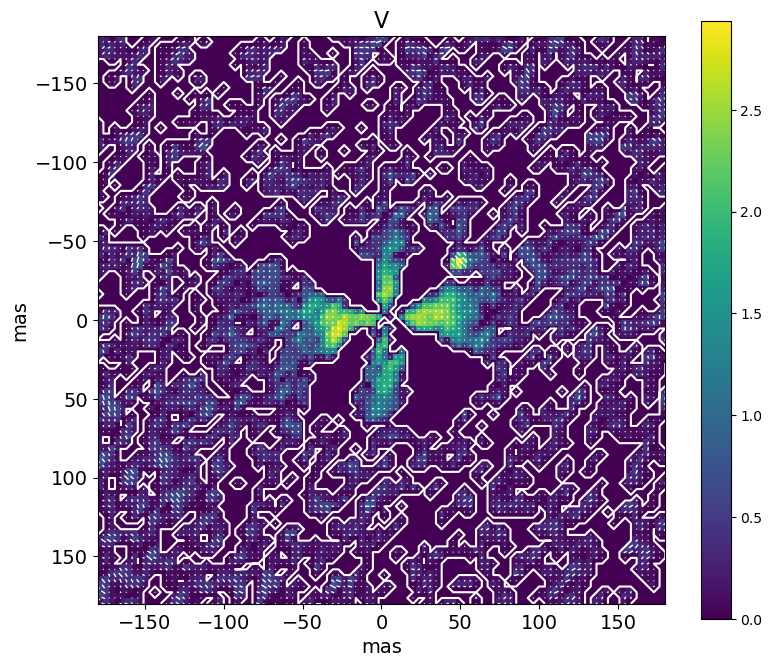

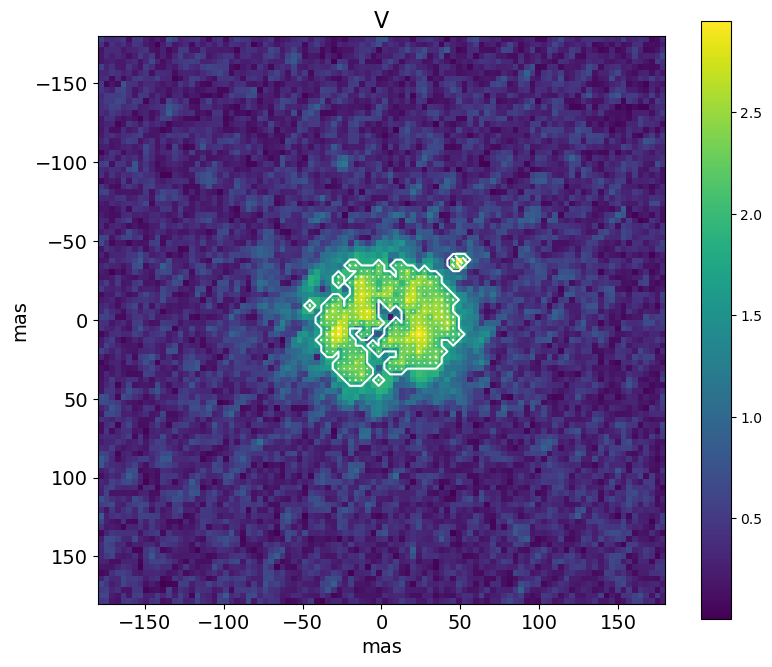

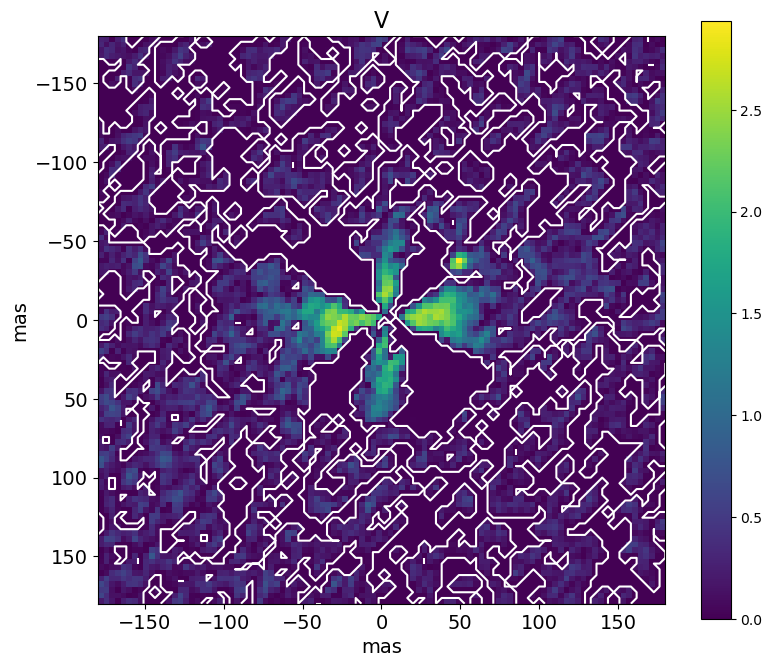

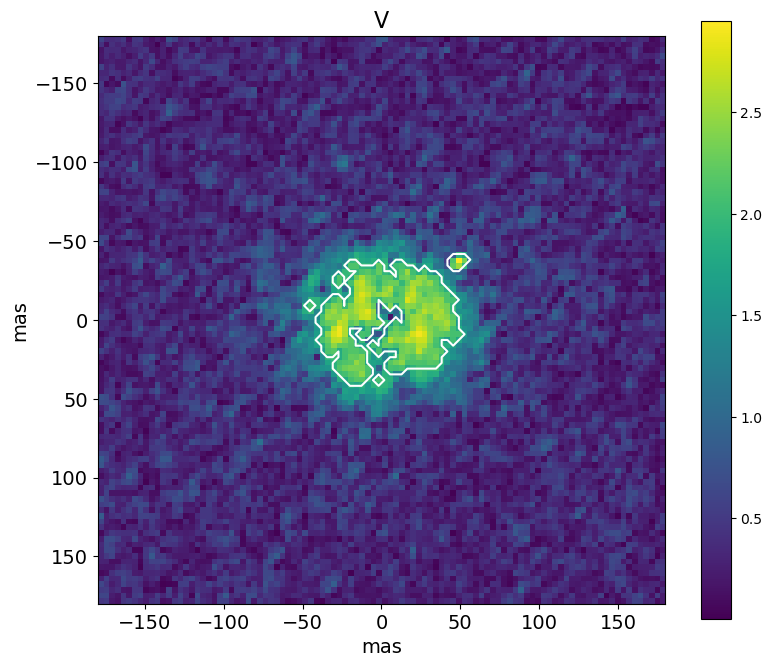

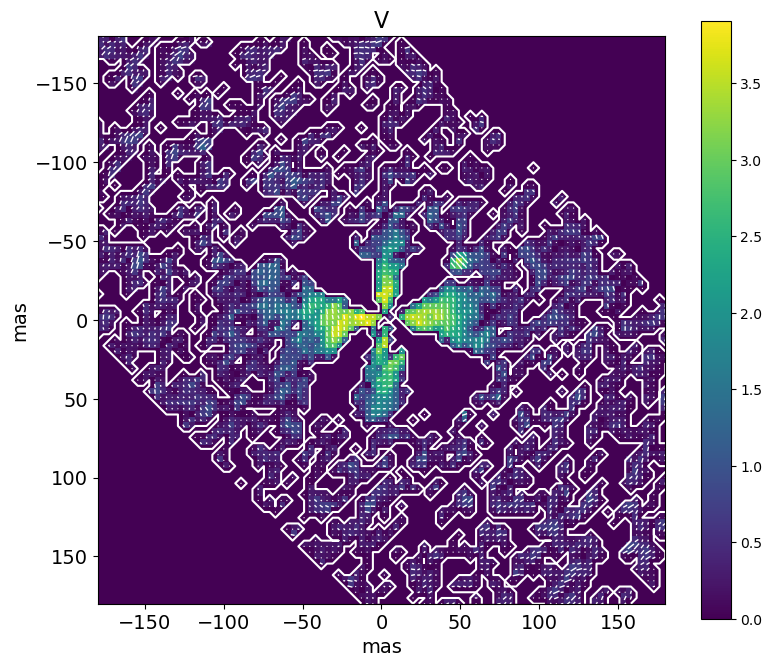

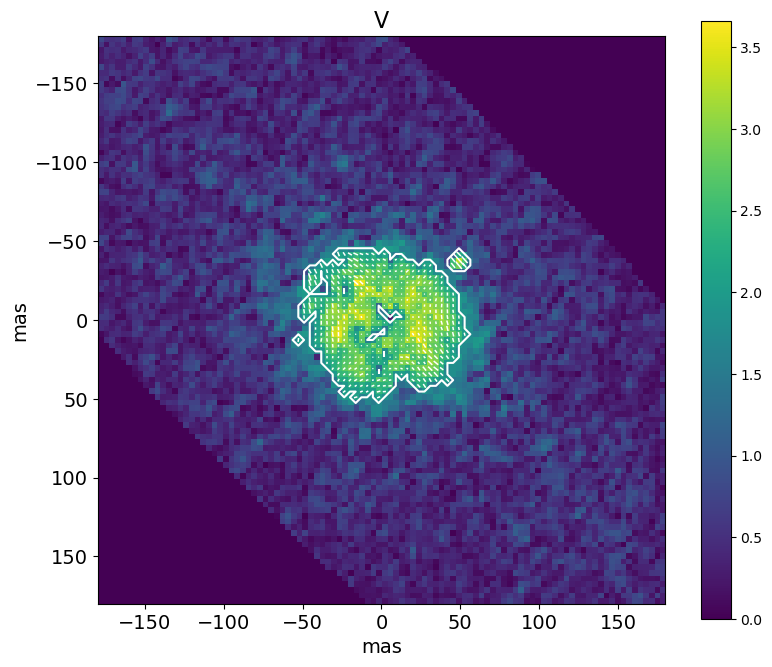

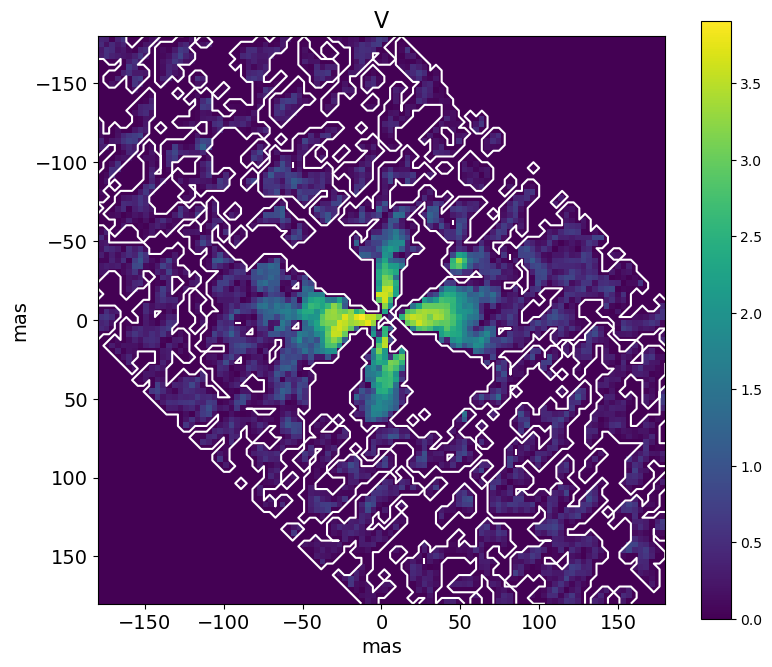

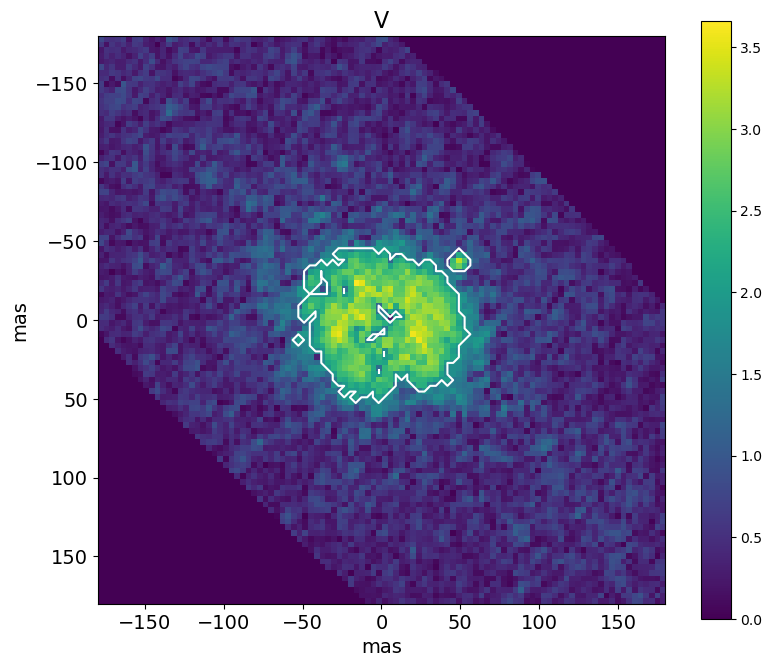

<Figure size 1200x400 with 0 Axes>

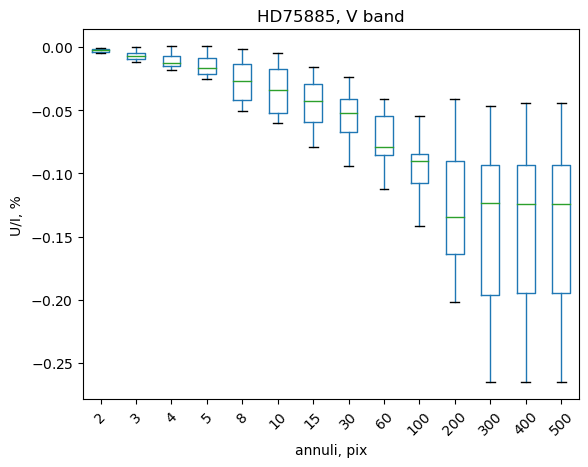

<Figure size 1200x400 with 0 Axes>

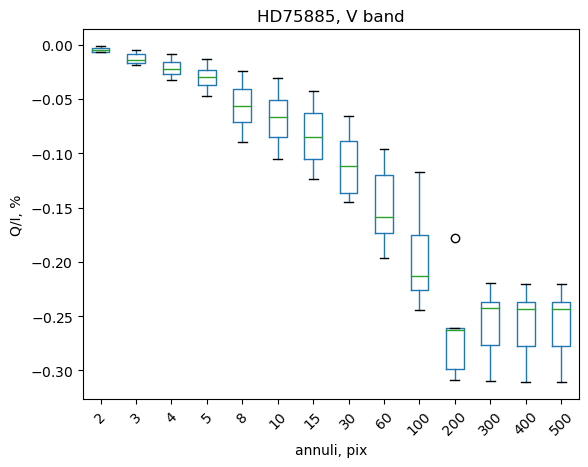

<Figure size 1200x400 with 0 Axes>

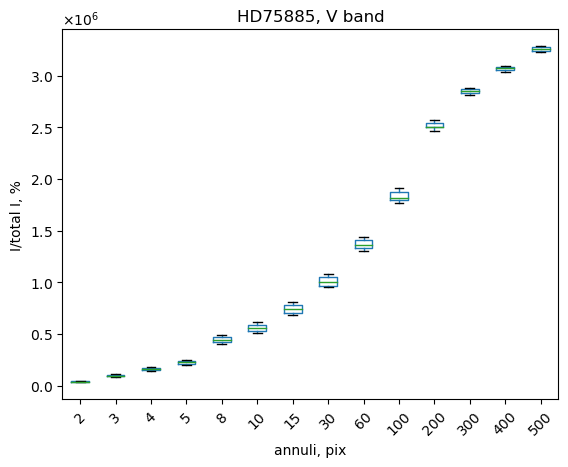

I
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ/I[%]  sumQ_phi/I[%] sumPI/I[%] 
telescope corrected 

combined                       9.296      14.942      16.766     -0.136     0.163      0.495       

std from array                 3.650      30.355      35.914     0.022      0.010      0.021       

mean from array                20.811     38.409      53.983     -0.136     0.163      0.495       

tel+corr for unres 

combined                       8.303      12.685      14.823     0.030      0.074      0.210       

std from array                 3.700      32.176      36.997     0.043      0.007      0.014       

mean from array                20.596     36.130      52.814     0.026      0.151      0.447       

 +corr for PSF smear 

combined                       9.399      16.411      12.392     nan        0.116      0.285       

std from array                 3.500      8.983       6.354      nan        0.017      0.021       

mean from array       

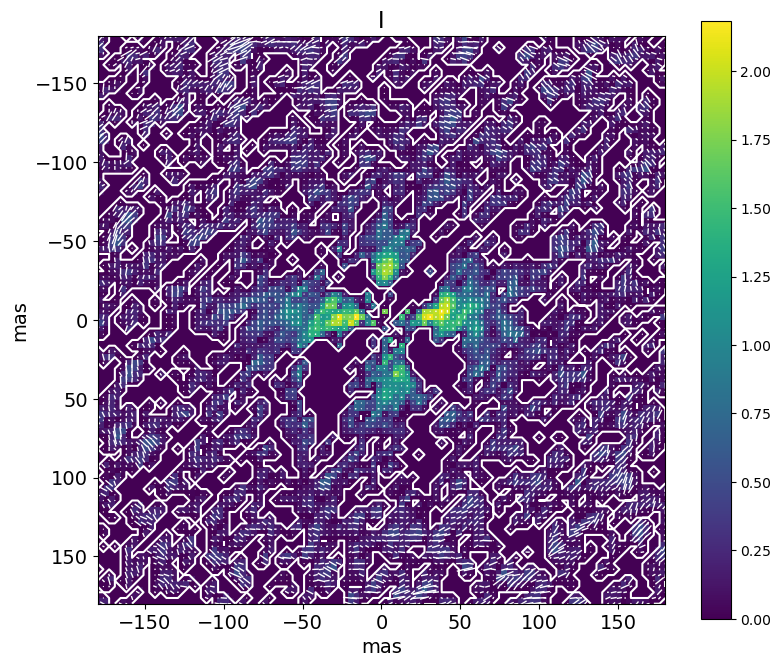

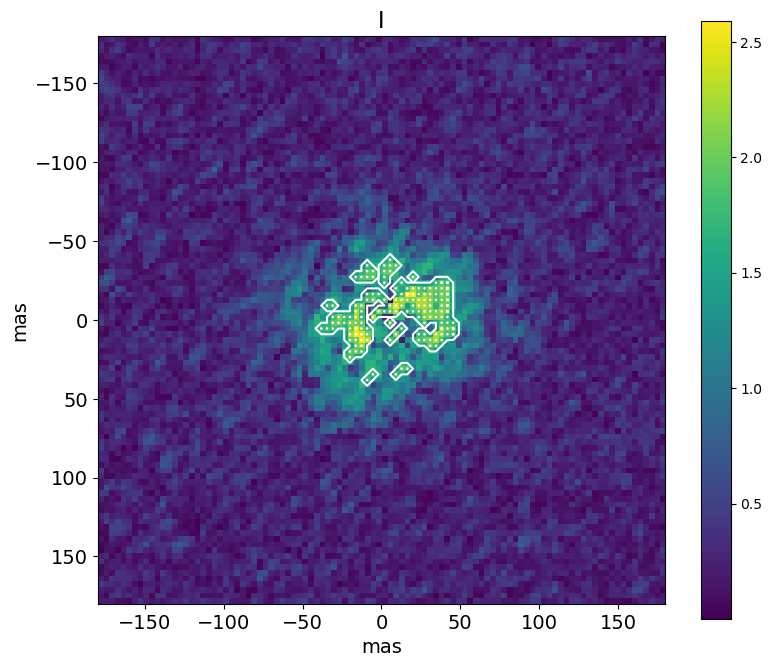

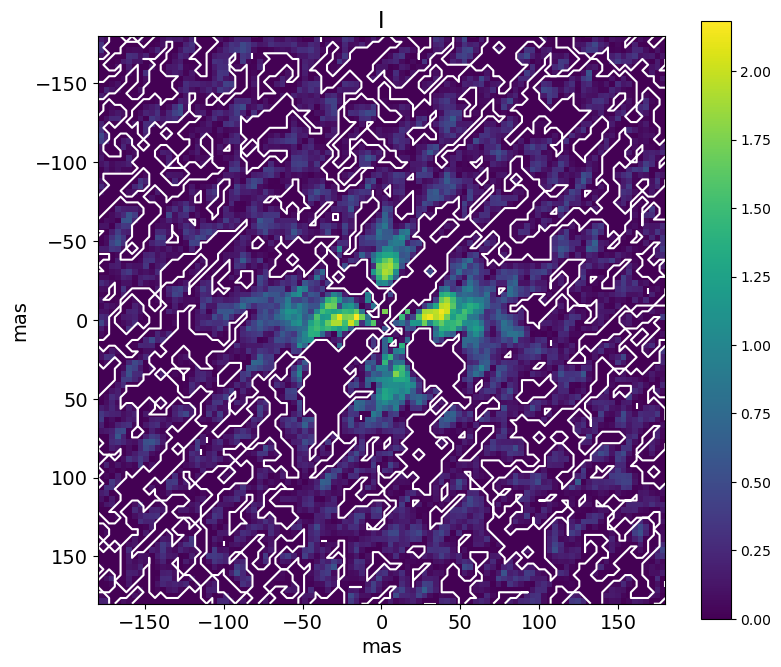

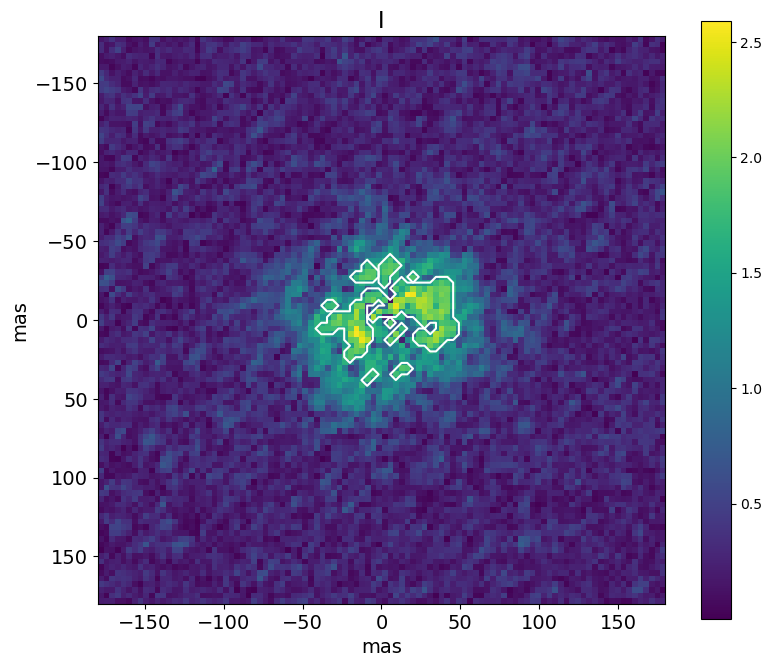

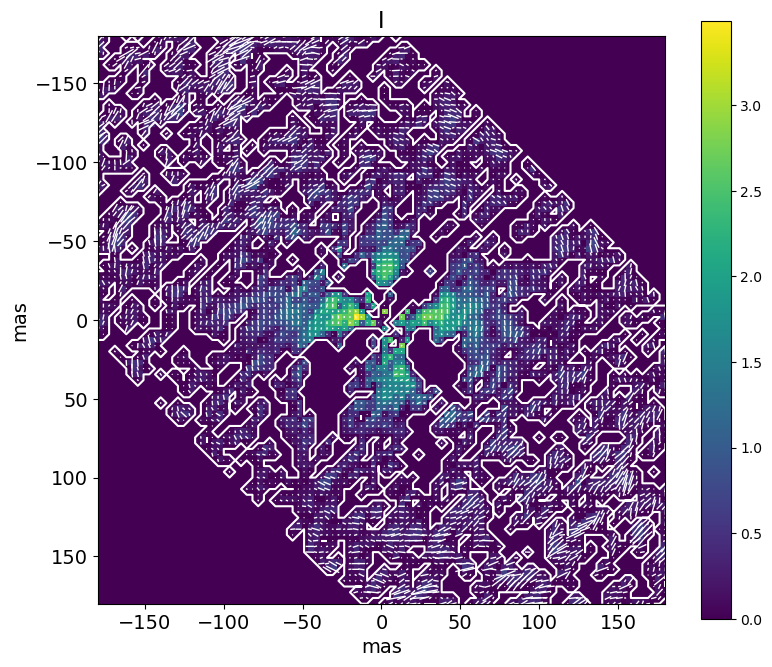

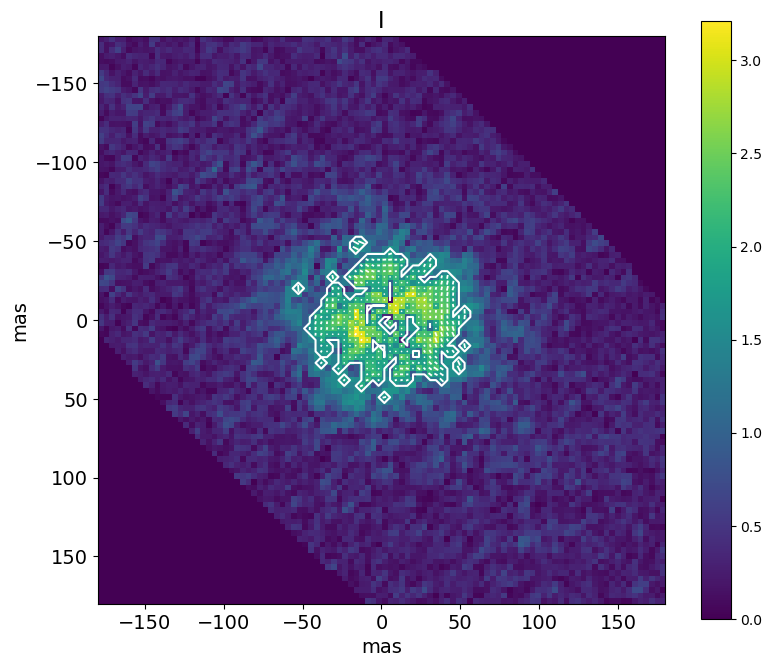

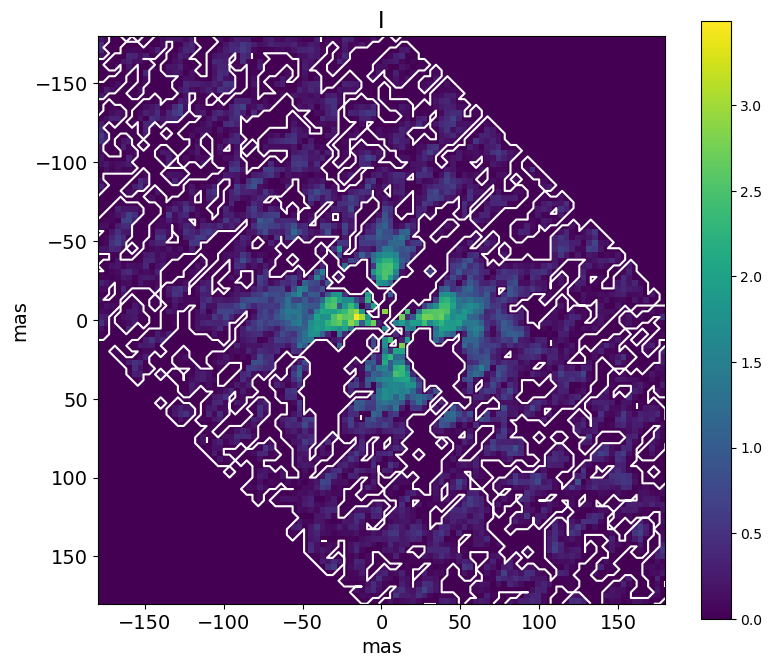

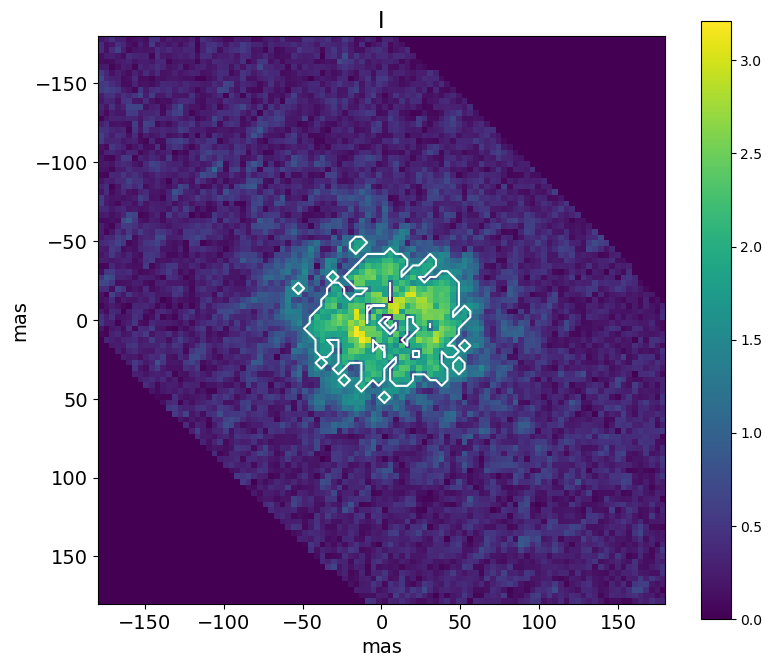

<Figure size 1200x400 with 0 Axes>

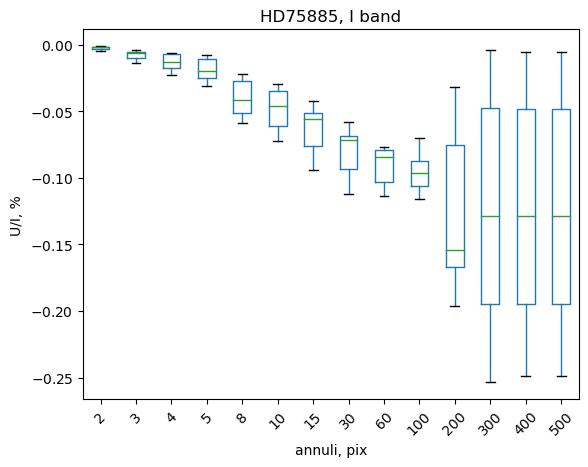

<Figure size 1200x400 with 0 Axes>

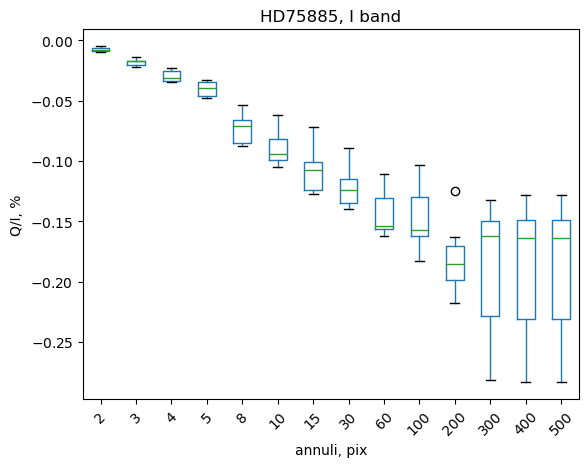

<Figure size 1200x400 with 0 Axes>

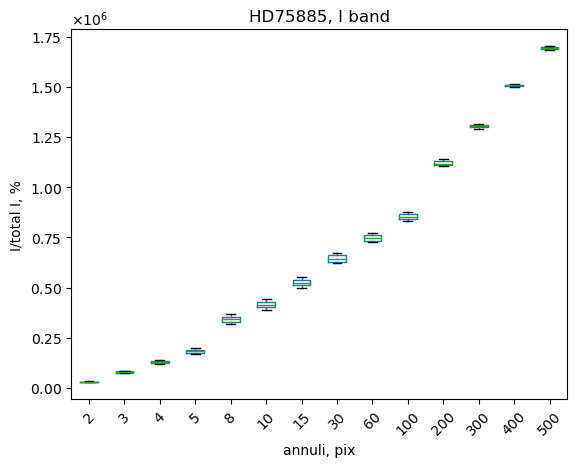

In [4]:



print(star)
figfolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr_Ref/'
createfolder(figfolder)
figfolder=figfolder+star+'/'
createfolder(figfolder)

figfolder_snr=figfolder+'SNR/'
createfolder(figfolder_snr)

if apperture==True:
    figfolder_apper=figfolder+'apperture_pol/'
    createfolder(figfolder_apper)
    annuli_list=[2,3,4,5,8,10,15,30,60,100,200,300,400,500]
    columns_q=[]
    columns_u=[]
    columns_psf=[]
    for i_r in annuli_list:
        columns_q.append('q_sum_'+str(i_r))
        columns_u.append('u_sum_'+str(i_r))
        columns_psf.append('psf_sum_'+str(i_r))

#limit for normalisation
normlim=45
correction_radius=3

output_filename = figfolder+star+'_'+'_stats.txt'

if star=='UMon': #as it was already corrected for the telescope polarisation before filtering
    dir_tell ='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'UMon_data/HansMartin/all/'
else:
    dir_tell='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/telescope_corr_HMS/'+star+'/'    #telescope correction was performed only for the selected data


with open(output_filename, 'w') as file_print:

    for fittype in fittypes:
        print(band[int(fittype)-1])
        print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} ".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI","sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]"))
        if stars_type[star]=='sci' and star!='AR_Pup_dc_notnorm':
            f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
            f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
        elif star=='AR_Pup_dc_notnorm':
            f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_qphi_circular_f_psf_50.fits')
            f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_pi_circular_f_psf_50.fits')
        
        iq_arr=[]
        iu_arr=[]
        q_arr=[]
        u_arr=[]
        i_arr=[]
        q_phi_arr=[]
        u_phi_arr=[]
        pi_arr=[]
        
        qforn,_,_,_= load_tel_corr(dir_tell,fittype,list(filtered_process_dict.keys())[0])
        n=qforn.shape[0]
         #Creating grid         
        xr = np.linspace(-n/2, n/2, num=n)
        yr = np.linspace(-n/2, n/2, num=n)
        x0 = 0.5
        y0 = 0.5
        xr = xr-x0
        yr = yr-y0
        Xr, Yr = np.meshgrid(xr, yr)
        R = np.sqrt(Xr**2 + Yr**2)
        phi = np.arctan(Yr/Xr)
        
        
        df = pd.DataFrame.from_dict(filtered_process_dict,orient='index',columns=['process'])
        if apperture==True: df_apper = pd.DataFrame.from_dict(filtered_process_dict,orient='index',columns=['process'])    
    
        for key in filtered_process_dict.keys():
            
            q,u,q_phi,u_phi= load_tel_corr(dir_tell,fittype,key)
            q_phi=q_phi*(q_phi>=0)+1e-16*(q_phi<0) #we are looking only on positive q_phi

            pi=np.sqrt(q*q+u*u)
            process=filtered_process_dict[key]
            dirName=dirdat+'cam'+fittype+'/'
            iq,iu,i= load_I(dirName,process) #this is loaded from filtered data, as telescope polarisation correction does not affect the Itot
            
            iq_arr.append(iq)
            iu_arr.append(iu)
            q_arr.append(q)
            u_arr.append(u)
            i_arr.append(i)
            q_phi_arr.append(q_phi)
            u_phi_arr.append(u_phi)
            pi_arr.append(pi)
                        
            mask=(R<=normlim)
            I_sum=np.sum(i[R<=1500/ps])
            q_sum0=np.sum(q[mask])
            u_sum0=np.sum(u[mask])
            qphi_sum0=np.sum(q_phi[mask])
            pi_sum0=np.sum(pi[mask])
            fwhm=find_FWHM (i,n,ps,figfolder)
            aolp_all=np.rad2deg(0.5*np.arctan2(u_sum0, q_sum0))
            #print(aolp_unres)
            if aolp_all<0 : 
                aolp_all=aolp_all+180
            dolp_all=np.sum(np.sqrt(u*u+q*q)*(R<=normlim))/I_sum*100


            
            df.loc[key,'tel_cor_max_DoLP']=np.max(np.divide(q_phi,i,where=i!=0)*(R<=50)*(R>1))*100
            df.loc[key,'tel_cor_max_Q_phi']=np.max(q_phi)
            df.loc[key,'tel_cor_max_PI']=np.max(pi)
            df.loc[key,'tel_cor_q_sum/I']=q_sum0/I_sum*100
            df.loc[key,'tel_cor_qphi_sum/I']=qphi_sum0/I_sum*100
            df.loc[key,'tel_cor_pi_sum/I']=pi_sum0/I_sum*100
            df.loc[key,'FWHM']=fwhm*ps
            df.loc[key,'dolp_all,[%]']=dolp_all
            df.loc[key,'aolp_all']=aolp_all
            
            if apperture==True:
                for i_r in annuli_list:
                    psf_sum, q_sum, u_sum=ap(0,i_r,R,q,u,i)
                    df_apper.loc[key,'psf_sum_'+str(i_r)]=psf_sum
                    df_apper.loc[key,'q_sum_'+str(i_r)]=q_sum/I_sum*100
                    df_apper.loc[key,'u_sum_'+str(i_r)]=u_sum/I_sum*100

            
            dolp_unres,aolp_unres,q_corr,u_corr=calculate_unresolved(3, q, u,i,ps,R,normlim)
            df.loc[key,'aolp_unres']=aolp_unres
            df.loc[key,'dolp_unres,[%]']=dolp_unres*100
            q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
            q_phi_corr = (q_phi_corr>=0)*q_phi_corr +  (q_phi_corr <0 )*1e-16
            u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
            pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
            aolp_corr=0.5*np.arctan2(u_corr, q_corr)
            
            q_sum=np.sum(q_corr[mask])
            qphi_sum=np.sum(q_phi_corr[mask])
            pi_sum=np.sum(pi_corr[mask])
          
            df.loc[key,'unres_cor_max_DoLP']=np.max(np.divide(q_phi_corr,i,where=i!=0)*(R<=50)*(R>1))*100
            df.loc[key,'unres_cor_max_Q_phi']=np.max(q_phi_corr)
            df.loc[key,'unres_cor_max_PI']=np.max(pi_corr)
            df.loc[key,'unres_cor_q_sum/I']=q_sum/I_sum*100
            df.loc[key,'unres_cor_qphi_sum/I']=qphi_sum/I_sum*100
            df.loc[key,'unres_cor_pi_sum/I']=pi_sum/I_sum*100
            
            
            

            q_phi_corr_smearing=q_phi_corr*f_q
            pi_corr_smearing=pi_corr*f_pi
            mask=(R<=normlim)
            qphi_smearing_sum=np.sum(q_phi_corr_smearing[mask])
            pi_smearing_sum=np.sum(pi_corr_smearing[mask])

            df.loc[key,'psf_cor_max_DoLP']=np.max(np.divide(q_phi_corr_smearing,i,where=i!=0)*(R<=50)*(R>1))*100
            df.loc[key,'psf_cor_max_Q_phi']=np.max(q_phi_corr_smearing)
            df.loc[key,'psf_cor_max_PI']=np.max(pi_corr_smearing)
            df.loc[key,'psf_cor_qphi_sum/I']=qphi_smearing_sum/I_sum*100
            df.loc[key,'psf_cor_pi_sum/I']=pi_smearing_sum/I_sum*100



            for n_rad in [70]:
                noise_q_phi=np.std(q_phi[(R>=n_rad)*(R<n_rad+20)])
                noise_median=np.median(q_phi[(R>=n_rad)*(R<n_rad+20)])
                noise_max=np.max(q_phi[(R>=n_rad)*(R<n_rad+20)])
                noise_pi=np.std(pi[(R>=n_rad)*(R<n_rad+20)])
                noise_median_pi=np.median(pi[(R>=n_rad)*(R<n_rad+20)])
            df.loc[key,'noise_q_phi_std']=noise_q_phi
            df.loc[key,'noise_q_phi_median']=noise_median
            df.loc[key,'noise_q_phi_max']=noise_max
            df.loc[key,'noise_pi_std']=noise_pi
            df.loc[key,'noise_pi_median']=noise_median_pi

        file_print.write(str(band[int(fittype)-1])+'\n')
        file_print.write("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI","sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]"))

        

        iq_arr=np.array(iq_arr)
        iu_arr=np.array(iu_arr)
        q_arr=np.array(q_arr)
        u_arr=np.array(u_arr)
        q_phi_arr=np.array(q_phi_arr)
        u_phi_arr=np.array(u_phi_arr)
        pi_arr=np.array(pi_arr)
        i_arr=np.array(i_arr)


        q_mean_comb=np.mean(q_arr,axis=0)
        u_mean_comb=np.mean(u_arr,axis=0)
        iq_mean_comb=np.mean(iq_arr,axis=0)
        iu_mean_comb=np.mean(iu_arr,axis=0)
        i_mean_comb=np.mean(i_arr,axis=0)
        pi_mean_comb=np.mean(pi_arr,axis=0)
        q_phi_mean_comb=np.mean(q_phi_arr,axis=0)
        u_phi_mean_comb=np.mean(u_phi_arr,axis=0)



        if star=='AR_Pup' or star=='AR_Pup_dc_notnorm':
            lim=100       
        else:
            lim=50       

        #Initial aperture calculations for the meancombined data and writting to the file
        frac=np.max(np.divide(q_phi_mean_comb,i_mean_comb,where=i_mean_comb!=0)*(R<=50)*(R>1))*100  
        mask=(R<=normlim)
        q_sum=np.sum(q_mean_comb[mask])
        qphi_sum=np.sum(q_phi_mean_comb[mask])
        I_sum=np.sum(i_mean_comb[R<=1500/ps])
        pi_sum=np.sum(pi_mean_comb[mask])

        u_sum=np.sum(u_mean_comb[mask])
        

       
    
        
        
        
        
        fwhm=find_FWHM (i_mean_comb,n,ps,figfolder,band[int(fittype)-1]+'_gauss_mean_combined')
        mask=(R<=1500/ps)

        #calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
        normalisation=np.sum(i_mean_comb[mask])
        peak_i=np.max(i_mean_comb*(R<normlim))/normalisation
        peak_pi=np.max(pi_mean_comb*(R<normlim))/normalisation
        peak_q_phi=np.max(q_phi_mean_comb*(R<normlim))/normalisation #migh be less informative than PI because of unresolved signal in the center
       
        aolp_all=np.rad2deg(0.5*np.arctan2(u_sum, q_sum))
        #print(aolp_unres)
        if aolp_all<0 : 
            aolp_all=aolp_all+180
        dolp_all=np.sum(np.sqrt(u*u+ q*q)*(R<=normlim))/normalisation*100

    
        line = 'telescope corrected \n'
        print(line)
        file_print.write(line)
        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('combined',
            frac, np.max(q_phi_mean_comb), np.max(pi_mean_comb), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)
        file_print.write(line) 
        
        
        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('std from array',
            df.xs('tel_cor_max_DoLP',axis=1).std(), df.xs('tel_cor_max_Q_phi',axis=1).std(),
            df.xs('tel_cor_max_PI',axis=1).std(), df.xs('tel_cor_q_sum/I',axis=1).std(),
            df.xs('tel_cor_qphi_sum/I',axis=1).std(), df.xs('tel_cor_pi_sum/I',axis=1).std())
        print(line)
        file_print.write(line) 
        
        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('mean from array',
            df.xs('tel_cor_max_DoLP',axis=1).mean(), df.xs('tel_cor_max_Q_phi',axis=1).mean(),
            df.xs('tel_cor_max_PI',axis=1).mean(), df.xs('tel_cor_q_sum/I',axis=1).mean(),
            df.xs('tel_cor_qphi_sum/I',axis=1).mean(), df.xs('tel_cor_pi_sum/I',axis=1).mean())
        print(line)
        file_print.write(line) 
        
        
        
        

        #plotting images for the meancombined data and save to fits
        filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}

        for fileindex,image1 in enumerate([pi_mean_comb,q_phi_mean_comb, u_phi_mean_comb,q_mean_comb,u_mean_comb,i_mean_comb]):
            out_fits = fits.HDUList(fits.PrimaryHDU(image1))                  # create output fits structure
            out_fits.writeto(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_meancombined.fits', overwrite = True)                       # write output

            image_an = image1*(R<250)
            image=np.arcsinh(image_an)
            fig, ax = plt.subplots()
            f.plottingroutinemas(image,lim,ps,n,star,ax)        
            f.scale_mas(star,ax)  

            plt.title(star+', '+filename[fileindex]+', '+band[int(fittype)-1]+', mean combined') 
            plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+'_meancombined.jpeg',bbox_inches='tight', pad_inches=0.1)
            #plt.show()
            plt.close()


       
        
        
   
        dolp_unres,aolp_unres,q_corr,u_corr=calculate_unresolved(correction_radius, q_mean_comb, u_mean_comb,i_mean_comb,ps,R,normlim)
       
        q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
        q_phi_corr = (q_phi_corr> 0)*q_phi_corr +  (q_phi_corr <=0 )*1e-16
        u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
        pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
        aolp_corr=0.5*np.arctan2(u_corr, q_corr)
        
        dolp_corr=np.divide(q_phi_corr,i_mean_comb,where=i_mean_comb!=0)*(R<=50)#*(R>1)
 
        
        
        
        #plotImage(dolp_corr,50)
        #plt.show()
        #plt.close()


        frac =np.max(dolp_corr)*100
        
        mask=(R<=normlim)
        q_sum=np.sum(q_corr[mask])
        qphi_sum=np.sum(q_phi_corr[mask])
        pi_sum=np.sum(pi_corr[mask])
        
        line = 'tel+corr for unres \n'
        print(line)
        file_print.write(line)
        
        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('combined',
            frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)   
        file_print.write(line) 
                
        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('std from array',
            df.xs('unres_cor_max_DoLP',axis=1).std(), df.xs('unres_cor_max_Q_phi',axis=1).std(),
            df.xs('unres_cor_max_PI',axis=1).std(), df.xs('unres_cor_q_sum/I',axis=1).std(),
            df.xs('unres_cor_qphi_sum/I',axis=1).std(), df.xs('unres_cor_pi_sum/I',axis=1).std())
        print(line)
        file_print.write(line) 
        
        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('mean from array',
            df.xs('unres_cor_max_DoLP',axis=1).mean(), df.xs('unres_cor_max_Q_phi',axis=1).mean(),
            df.xs('unres_cor_max_PI',axis=1).mean(), df.xs('unres_cor_q_sum/I',axis=1).mean(),
            df.xs('unres_cor_qphi_sum/I',axis=1).mean(), df.xs('unres_cor_pi_sum/I',axis=1).mean())
        print(line)
        file_print.write(line) 
        
         #correction of PSF smearing for the mean-combined data
        mask=(R<=normlim)
       
        
        if stars_type[star]=='sci':
        
            q_phi_corr_smearing=q_phi_corr*f_q
            pi_corr_smearing=pi_corr*f_pi

            dolp_corr_smearing=np.divide(q_phi_corr_smearing,i_mean_comb,where=i_mean_comb!=0)*(R<=50)#*(R>1)


            qphi_corr_smearing_sum=np.sum(q_phi_corr_smearing[mask])
            pi_corr_smearing_sum=np.sum(pi_corr_smearing[mask])


        
        if stars_type[star]=='sci' and star!='AR_Pup_dc_notnorm':
        
            frac_corr_smearing =np.max(dolp_corr_smearing)*100
            line = ' +corr for PSF smear \n'
            print(line)
            file_print.write(line) 
            line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('combined',
                frac_corr_smearing, np.max(q_phi_corr_smearing), np.max(pi_corr_smearing), np.NaN, qphi_corr_smearing_sum/I_sum*100, pi_corr_smearing_sum/I_sum*100)
            print(line)
            file_print.write(line) 
            
            line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('std from array',
                df.xs('psf_cor_max_DoLP',axis=1).std(), df.xs('psf_cor_max_Q_phi',axis=1).std(),
                df.xs('psf_cor_max_PI',axis=1).std(), np.nan,
                df.xs('psf_cor_qphi_sum/I',axis=1).std(), df.xs('psf_cor_pi_sum/I',axis=1).std())
            print(line)
            file_print.write(line) 

            line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('mean from array',
                df.xs('psf_cor_max_DoLP',axis=1).mean(), df.xs('psf_cor_max_Q_phi',axis=1).mean(),
                df.xs('psf_cor_max_PI',axis=1).mean(), np.nan,
                df.xs('psf_cor_qphi_sum/I',axis=1).mean(), df.xs('psf_cor_pi_sum/I',axis=1).mean())
            print(line)
            file_print.write(line) 

            
            

            filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr',3:'Q_corr',4:'U_corr',5:'Q_phi_corr_smearing',6:'PI_corr_smearing'}

            for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr,q_corr,u_corr,q_phi_corr_smearing,pi_corr_smearing]):
                out_fits = fits.HDUList(fits.PrimaryHDU(image1))                  # create output fits structure
                if fileindex<5:
                    out_fits.writeto(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres.fits', overwrite = True)                       # write output
                if fileindex>=5:
                    out_fits.writeto(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres+PSF_smear.fits', overwrite = True)                       # write output
                    print(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres+PSF_smear.fits')
                image_an = image1*(R<250)
                image=np.arcsinh(image_an)
                fig, ax = plt.subplots()
                f.plottingroutinemas(image,lim,ps,n,star,ax)        
                f.scale_mas(star,ax)  
                if fileindex<5:
                    plt.title(star+', '+filename[fileindex]+', '+band[int(fittype)-1]+', tel+unres') 
                    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres.jpeg',bbox_inches='tight', pad_inches=0.1)

                if fileindex>=5:
                    plt.title(star+', '+filename[fileindex]+', '+band[int(fittype)-1]+', tel+unres+PSF') 
                    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres+PSF.jpeg',bbox_inches='tight', pad_inches=0.1)
                #plt.show()
                plt.close()
        else:
            
            filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr',3:'Q_corr',4:'U_corr'}

            for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr,q_corr,u_corr]):
                out_fits = fits.HDUList(fits.PrimaryHDU(image1))                  # create output fits structure
                if fileindex<5:
                    out_fits.writeto(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres.fits', overwrite = True)                       # write output
                    image_an = image1*(R<250)
                image=np.arcsinh(image_an)
                fig, ax = plt.subplots()
                f.plottingroutinemas(image,lim,ps,n,star,ax)        
                f.scale_mas(star,ax)  
                if fileindex<5:
                    plt.title(star+', '+filename[fileindex]+', '+band[int(fittype)-1]+', tel+unres') 
                    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres.jpeg',bbox_inches='tight', pad_inches=0.1)

                if fileindex>=5:
                    plt.title(star+', '+filename[fileindex]+', '+band[int(fittype)-1]+', tel+unres+PSF') 
                    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_tel+unres+PSF.jpeg',bbox_inches='tight', pad_inches=0.1)
                #plt.show()
                plt.close()
        

        
        print('FWHM, mas')
        print('mean       std')
        print("{:<10.3f} {:<10.3f}\n".format(df.xs('FWHM',axis=1).mean(),df.xs('FWHM',axis=1).std()))
        print('Unresolved')
        print('DoLP, % of total I')
        print('combined   std         mean')
        print("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(dolp_unres*100, df.xs('dolp_unres,[%]',axis=1).std(),df.xs('dolp_unres,[%]',axis=1).mean()))    
        print('AoLP')
        print('combined   std         mean')
        print("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(aolp_unres, df.xs('aolp_unres',axis=1).std(),df.xs('aolp_unres',axis=1).mean()))    
        print('Total')
        print('DoLP, % of total I')
        print('combined   std         mean')
        print("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(dolp_all, df.xs('dolp_all,[%]',axis=1).std(),df.xs('dolp_all,[%]',axis=1).mean()))    
        print('AoLP')
        print('combined   std         mean')
        print("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(aolp_all, df.xs('aolp_all',axis=1).std(),df.xs('aolp_all',axis=1).mean()))    
        
        
        
        file_print.write('FWHM, mas \n')
        file_print.write('mean       std \n')
        file_print.write("{:<10.3f} {:<10.3f}\n".format(df.xs('FWHM',axis=1).mean(),df.xs('FWHM',axis=1).std()))
        file_print.write('Unresolved \n')
        file_print.write('DoLP, % of total I \n')
        file_print.write('combined   std         mean \n')
        file_print.write("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(dolp_unres*100, df.xs('dolp_unres,[%]',axis=1).std(),df.xs('dolp_unres,[%]',axis=1).mean()))    
        file_print.write('AoLP \n')
        file_print.write('combined   std         mean \n')
        file_print.write("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(aolp_unres, df.xs('aolp_unres',axis=1).std(),df.xs('aolp_unres',axis=1).mean()))    
        
        file_print.write('Total \n')
        file_print.write('DoLP, % of total I \n')
        file_print.write('combined   std         mean \n')
        file_print.write("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(dolp_all, df.xs('dolp_all,[%]',axis=1).std(),df.xs('dolp_all,[%]',axis=1).mean()))    
        file_print.write('AoLP \n')
        file_print.write('combined   std         mean \n')
        file_print.write("{:<10.3f} {:<10.3f}  {:<10.3f}  \n".format(aolp_all, df.xs('aolp_all',axis=1).std(),df.xs('aolp_all',axis=1).mean()))    
        
        
        
        plot_AoLP(ps,q_corr,u_corr,R,i,q_phi_corr,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_qphi_aolp_not_smear.png',True, df.xs('noise_q_phi_median',axis=1).median(),50,aolp_plot=True)
        plot_AoLP(ps,q_corr,u_corr,R,i,pi_corr,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_pi_aolp_not_smear.png',True, df.xs('noise_pi_median',axis=1).median(),50,aolp_plot=True)
        plot_AoLP(ps,q_corr,u_corr,R,i,q_phi_corr,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_qphi_not_smear.png',True, df.xs('noise_q_phi_median',axis=1).median(),50)
        plot_AoLP(ps,q_corr,u_corr,R,i,pi_corr,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_pi_not_smear.png',True, df.xs('noise_pi_median',axis=1).median(),50)
        
        plot_AoLP(ps,q_corr,u_corr,R,i,q_phi_corr_smearing,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_qphi_aolp_smear.png',True, df.xs('noise_q_phi_median',axis=1).median(),50,aolp_plot=True)
        plot_AoLP(ps,q_corr,u_corr,R,i,pi_corr_smearing,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_pi_aolp_smear.png',True, df.xs('noise_pi_median',axis=1).median(),50,aolp_plot=True)
        plot_AoLP(ps,q_corr,u_corr,R,i,q_phi_corr_smearing,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_qphi_smear.png',True, df.xs('noise_q_phi_median',axis=1).median(),50)
        plot_AoLP(ps,q_corr,u_corr,R,i,pi_corr_smearing,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_pi_smear.png',True, df.xs('noise_pi_median',axis=1).median(),50)
        
        
        
        if apperture==True:
            annuli=annuli_list

            plt.figure(figsize=(12, 4))
            df_apper[columns_u].plot(kind='box')
            positions = range(1, len(columns_u) + 1)
            plt.xticks(positions, annuli)
            plt.ylabel('U/I, %') 
            plt.xlabel('annuli, pix')
            plt.title(star + ', '+band[int(fittype)-1]+' band')
            formatter = plt.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((-2, 2))
            plt.gca().yaxis.set_major_formatter(formatter)
            ax = plt.subplot(111)
            plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
            plt.savefig(figfolder_apper + star + '_'+band[int(fittype)-1]+'_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
            plt.show()
            plt.close()




            plt.figure(figsize=(12, 4))
            # Plot each current data with the corresponding label and cycle numbers in the legend
            df_apper[columns_q].plot(kind='box')
            plt.xticks(positions, annuli)
            plt.ylabel('Q/I, %')
            plt.xlabel('annuli, pix')
            plt.title(star + ', '+band[int(fittype)-1]+' band')
            formatter = plt.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((-2, 2))
            plt.gca().yaxis.set_major_formatter(formatter)
            plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
            plt.savefig(figfolder_apper + star + '_'+band[int(fittype)-1]+'_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
            plt.show()
            plt.close()



            plt.figure(figsize=(12, 4))
            # Plot each current data with the corresponding label and cycle numbers in the legend
            df_apper[columns_psf].plot(kind='box')
            plt.xticks(positions, annuli)
            plt.ylabel('I/total I, %')
            plt.xlabel('annuli, pix')
            plt.title(star + ', '+band[int(fittype)-1]+' band')
            formatter = plt.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((-2, 2))
            plt.gca().yaxis.set_major_formatter(formatter)
            plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
            plt.savefig(figfolder_apper + star + '_'+band[int(fittype)-1]+'_psf_annuli.png', bbox_inches='tight', pad_inches=0.1)
            plt.show()
            plt.close()



            if band[int(fittype)-1]=='V':
                df_V=df_apper
            if band[int(fittype)-1]=='I':
                df_I=df_apper

        
        
        

## Apperture Q/I and U/I

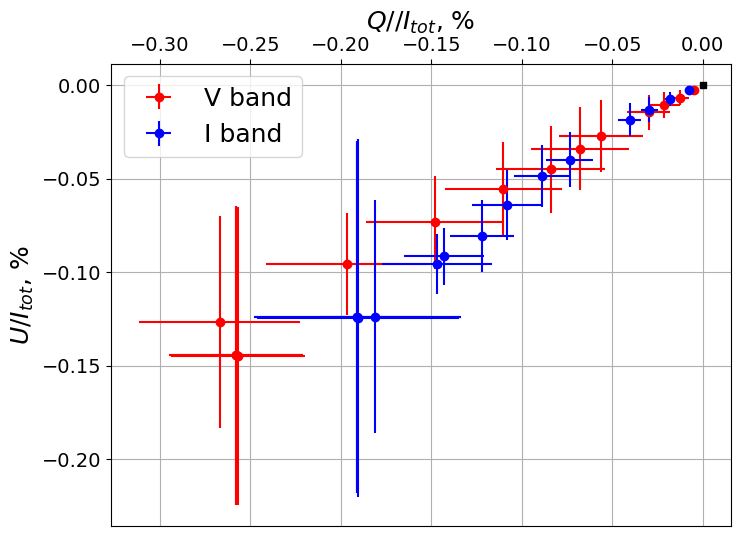

,q_sum_2,q_sum_3,q_sum_4,q_sum_5,q_sum_8,q_sum_10,q_sum_15,q_sum_30,q_sum_60,q_sum_100,q_sum_200,q_sum_300,q_sum_400,q_sum_500
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,-0.004655,-0.012697,-0.021339,-0.030034,-0.056312,-0.067711,-0.083988,-0.110205,-0.148210,-0.196850,-0.266902,-0.256749,-0.257752,-0.257752
std,0.002055,0.005137,0.008559,0.011658,0.022976,0.027012,0.030172,0.032434,0.038037,0.044523,0.044428,0.036832,0.036894,0.036894
min,-0.006647,-0.018537,-0.032569,-0.046818,-0.089283,-0.105584,-0.123330,-0.144399,-0.196298,-0.244742,-0.308658,-0.309840,-0.310776,-0.310776
25%,-0.006477,-0.016838,-0.027217,-0.037305,-0.071115,-0.084871,-0.105147,-0.136752,-0.173139,-0.225821,-0.298837,-0.276384,-0.277334,-0.277334
50%,-0.004970,-0.013681,-0.022398,-0.030097,-0.056454,-0.066768,-0.085360,-0.111331,-0.158892,-0.212964,-0.262674,-0.242409,-0.243427,-0.243427
75%,-0.003327,-0.008947,-0.015549,-0.023003,-0.041052,-0.050639,-0.063263,-0.088298,-0.120162,-0.175533,-0.260818,-0.236590,-0.237325,-0.237325
max,-0.001364,-0.005094,-0.008875,-0.012707,-0.024116,-0.030609,-0.042404,-0.065604,-0.095681,-0.117533,-0.177675,-0.219046,-0.220743,-0.220743


In [5]:
fig,ax=plt.subplots(figsize=(8, 6))
# Plot each current data with the corresponding label and cycle numbers in the legend
plt.errorbar(df_V[columns_q].mean(),df_V[columns_u].mean(),yerr=df_V[columns_u].std(), xerr=df_V[columns_q].std(),fmt='o', label='V band',color='red')
plt.errorbar(df_I[columns_q].mean(),df_I[columns_u].mean(),yerr=df_I[columns_u].std(), xerr=df_I[columns_q].std(),fmt='o', label='I band',color='blue')
ax.set_xlabel('$Q//I_{tot}$, %', fontsize=18)
plt.ylabel('$U/I_{tot}$, %', fontsize=18)
ax.xaxis.set_label_position('top')
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(0, 0, 's', markersize=4,color='black')
plt.grid(True,which='both')
plt.legend(loc='best', fontsize=18)
plt.savefig(figfolder_apper + star +'_QU.png', bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


df_V[columns_q].describe()